# **Sessa Empirical Estimator (SEE) Analysis**

- Josef Hasm A. Agunod
- Sharly Pia Rose S. Barago

---


## **📌 Background**

The **Sessa Empirical Estimator (SEE)** is a method used to estimate the duration of medication use when prescription details are missing. It does this by using **K-Means clustering** to find patterns in the time between prescriptions. These patterns help determine how long people are likely taking medications.

### **Disadvantages of K-Means Clustering**
- **Fixed Number of Clusters:** K-Means requires choosing the number of clusters in advance, which can lead to poor results if the choice is inaccurate.  
- **Sensitivity to Outliers:** The algorithm is easily influenced by outliers, potentially skewing the clustering.  
- **Assumption of Spherical Clusters:** K-Means assumes clusters are spherical and of similar size, which may not reflect real-world data patterns.  




---



# **Methodology**


 ## **1. Data Preprocessing**

####**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde

#### **Load Medication Event Data**

In [ ]:
# Load dataset function
def load_dataset(filepath):
    med_events = pd.read_csv(filepath)
    med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    med_events['eksd'] = pd.to_datetime(med_events['eksd'])
    return med_events

####**Filter Data by Selected Drug Code and Compute Event Intervals**

In [ ]:
# Preprocess data function
def preprocess_data(data, drug_code):
    drug_data = data[data['ATC'] == drug_code]
    drug_data = drug_data.sort_values(['pnr', 'eksd'])
    drug_data['prev_eksd'] = drug_data.groupby('pnr')['eksd'].shift(1)
    drug_data = drug_data.dropna(subset=['prev_eksd'])
    drug_data['event_interval'] = (drug_data['eksd'] - drug_data['prev_eksd']).dt.days
    return drug_data

####**Visualize Event Intervals Using ECDF**

In [ ]:
# Plot ECDF function
def plot_ecdf(event_intervals):
    ecdf = np.sort(event_intervals)
    y = np.arange(1, len(ecdf) + 1) / len(ecdf)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ecdf, y, marker='.', linestyle='none')
    plt.title('100% ECDF')
    plt.xlabel('Event Interval')
    plt.ylabel('ECDF')

    cutoff = np.percentile(ecdf, 80)
    filtered_intervals = event_intervals[event_intervals <= cutoff]

    plt.subplot(1, 2, 2)
    plt.plot(filtered_intervals, np.arange(1, len(filtered_intervals) + 1) / len(filtered_intervals),
             marker='.', linestyle='none')
    plt.title('80% ECDF')
    plt.xlabel('Event Interval')
    plt.ylabel('ECDF')
    plt.show()

    return filtered_intervals

####**Visualize the Density of Log-Transformed Event Intervals**

In [ ]:
# Plot Density function
def plot_density(filtered_intervals):
    log_intervals = np.log(filtered_intervals[filtered_intervals > 0])
    density = gaussian_kde(log_intervals)
    xs = np.linspace(log_intervals.min(), log_intervals.max(), 200)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, density(xs))
    plt.title('Density of Log(Event Interval)')
    plt.xlabel('Log(Event Interval)')
    plt.show()

    return log_intervals



---



##**2. SEE using K-Means Clustering**

Here, we applied K-Means to log-transformed event intervals, used silhouette scores to determine the optimal number of clusters, and visualized ECDF and density plots.

In [ ]:
# K-Means Clustering function
def kmeans_clustering(log_intervals):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_intervals.values.reshape(-1, 1))

    silhouette_scores = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        silhouette_scores.append(score)

    optimal_k = k_range[np.argmax(silhouette_scores)]

    plt.figure(figsize=(6, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for K-Means Clustering')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    kmeans = KMeans(n_clusters=optimal_k, random_state=1234)
    clusters = kmeans.fit_predict(scaled_data)

    return clusters



---



##**3. SEE using Agglomerative Clustering**

On this step we reapplied SEE steps using Agglomerative Clustering and compared clustering outcomes to K-Means results.

In [ ]:
# Agglomerative Clustering function
def agglomerative_clustering(log_intervals):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_intervals.values.reshape(-1, 1))

    agg_clustering = AgglomerativeClustering(n_clusters=2)
    clusters = agg_clustering.fit_predict(scaled_data)

    return clusters



---



##**4. Comparison and Analysis**

Here, we evaluated differences between clustering methods and assessed the suitability of each method for this dataset.

In [ ]:
# Summarize Clusters function
def summarize_clusters(event_intervals, clusters):
    cluster_df = pd.DataFrame({
        'event_interval': event_intervals,
        'cluster': clusters
    })

    summary = cluster_df.groupby('cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
    return summary

#### **Main Execution Example**

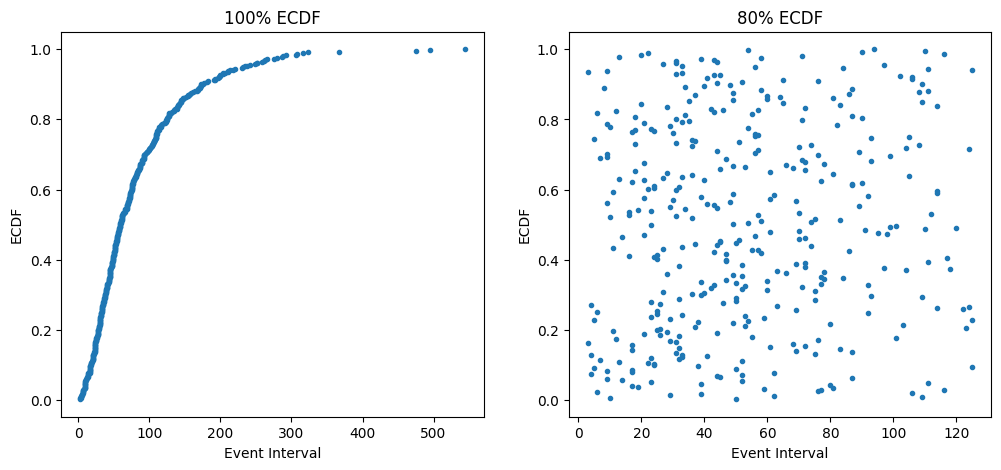

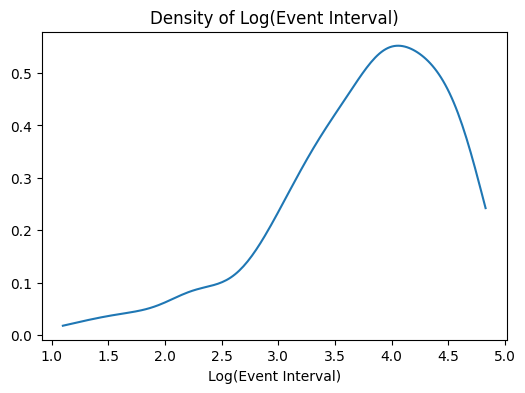

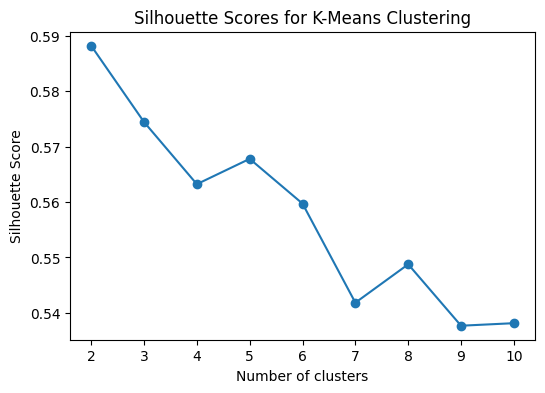

K-Means Clustering Summary:
    cluster  min  max  median
0        0    3   34    23.0
1        1   35  125    65.5
Agglomerative Clustering Summary:
    cluster  min  max  median
0        0    3   42    25.0
1        1   43  125    71.0


In [ ]:
if __name__ == "__main__":
    filepath = 'med_events.csv'
    med_events = load_dataset(filepath)

    drug_code = "medA"
    drug_data = preprocess_data(med_events, drug_code)

    filtered_intervals = plot_ecdf(drug_data['event_interval'])
    log_intervals = plot_density(filtered_intervals)

    # K-Means Clustering
    kmeans_clusters = kmeans_clustering(log_intervals)
    kmeans_summary = summarize_clusters(filtered_intervals, kmeans_clusters)
    print("K-Means Clustering Summary:\n", kmeans_summary)

    # Agglomerative Clustering
    agg_clusters = agglomerative_clustering(log_intervals)
    agg_summary = summarize_clusters(filtered_intervals, agg_clusters)
    print("Agglomerative Clustering Summary:\n", agg_summary)


##**Results Comparison**

#### K-Means Clustering Results:
- **Cluster 0:** Median interval of 23.0 days.
- **Cluster 1:** Median interval of 65.5 days.

#### Agglomerative Clustering Results:
- **Cluster 0:** Median interval of 25.0 days.
- **Cluster 1:** Median interval of 71.0 days.





---



##**Final Analysis**
While both methods identified similar cluster medians, Agglomerative Clustering demonstrated a slightly better separation of clusters. This method doesn’t require the number of clusters to be predefined and handles irregularly shaped clusters more effectively. Additionally, it is less sensitive to outliers compared to K-Means, making it more stable for datasets with varying prescription intervals.